## Assignment - 4: SVM - Apple Stock Price Time Series Forecasting
### ID: eo9232
### Name: Md Reza
### IE7860 - Winter 2022

In [1]:
import numpy as np
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt
from sklearn.svm import SVR

from pykalman import KalmanFilter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# Reading the dataset
aapl_df = pd.read_csv(r'AAPL.csv')
aapl_df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,1/4/2010,7.622500,7.660714,7.585000,7.643214,493729600,6.544687
1,1/5/2010,7.664286,7.699643,7.616071,7.656429,601904800,6.556001
2,1/6/2010,7.656429,7.686786,7.526786,7.534643,552160000,6.451719
3,1/7/2010,7.562500,7.571429,7.466071,7.520714,477131200,6.439792
4,1/8/2010,7.510714,7.571429,7.466429,7.570714,447610800,6.482607


## Data Preprocessing

In [3]:
# Create subset with Date & Closing value
aapl_close = pd.DataFrame(aapl_df['Close'])
aapl_close.index = pd.to_datetime(aapl_df['Date'])
aapl_close.head()

,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


## Handling missing values

In [4]:
aapl_close.isnull().any()

Close    False
dtype: bool

## Data Exploration 

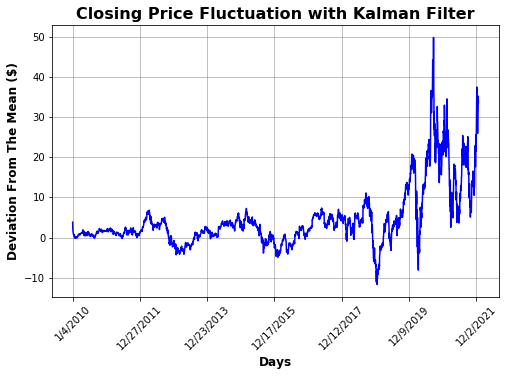

In [5]:
kf = KalmanFilter(transition_matrices = [1], observation_matrices = [1], initial_state_mean = 0, 
                         initial_state_covariance = 1, observation_covariance = 1,transition_covariance = 0.0001)
mean, cov = kf.filter(aapl_df['Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
plt.figure(figsize=(8,5))
plt.plot(aapl_df['Close'].values - mean, 'b', lw=1.5)
plt.xticks(range(0,aapl_df.shape[0],500),aapl_df['Date'].loc[::500],rotation=45)
plt.title("Closing Price Fluctuation with Kalman Filter", weight='bold', fontsize=16)
plt.ylabel("Deviation From The Mean ($)", weight='bold', fontsize=12)
plt.xlabel("Days", weight='bold', fontsize=12)
plt.grid(color = 'gray', linewidth = 0.5)
plt.show()

##### LJung Box Test for White Noise Detection

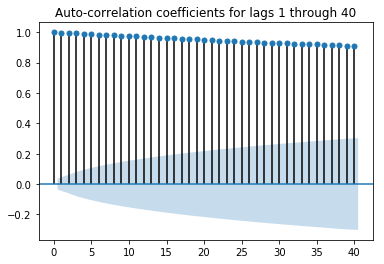

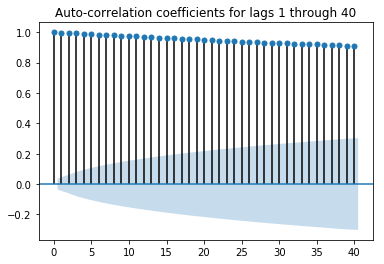

In [6]:
# Auto-correlation plot
import statsmodels.graphics.tsaplots as tsa
tsa.plot_acf(aapl_close['Close'], lags=40, alpha=0.05, title='Auto-correlation coefficients for lags 1 through 40')

## Find The Best Regressor Input 

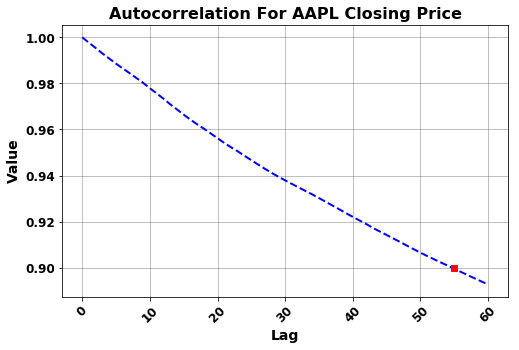

In [7]:
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(aapl_close, unbiased=True, nlags=60, qstat=True, fft=True, alpha = 0.05)
plt.figure(figsize=(8, 5))
plt.plot(pd.Series(acf_djia), color='b', linewidth=2, linestyle='dashed')
plt.plot(55, .9, "s", color ='r')
plt.title('Autocorrelation For AAPL Closing Price', weight='bold', fontsize=16)
plt.xlabel('Lag', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'gray', linewidth = 0.5)
plt.show()

##### From the correlation plot above, at the scale of 90% correlation, the best regressor input appeared to be 55.
##### Therefore, this model will use the past 55 days' stock's closing price to predict the closing price of any given day.

## Data Preperation

In [8]:
# Function to create regressor attributes

def regressor_attribs(aapl_df, attribute, list_of_prev_t_instants) :
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(aapl_df)
    aapl_df['datetime'] = aapl_df.index
    aapl_df.reset_index(drop=True)

    aapl_df_copy = aapl_df[start:end]
    aapl_df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(aapl_df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            aapl_df_copy = pd.concat([aapl_df_copy, foobar], sort=False, axis=1)
            
    aapl_df_copy.set_index(['datetime'], drop=True, inplace=True)
    return aapl_df_copy

# Create regressor attributes list
list_of_attributes = ['Close']
list_of_prev_t_instants = []
for i in range(1,56): #The best regressor input appeared to be 55.
    list_of_prev_t_instants.append(i)

In [9]:
# Create a new dataset with regressor attributes to include corresponding prices of the past 55 days to predict the closing price for any given day.
aapl_df_new = regressor_attribs(aapl_close, list_of_attributes, list_of_prev_t_instants)
aapl_df_new.shape

(2964, 56)

## Training & Test Split

In [10]:
# Training: 90% , Validation: 5%, & Testing: 5%

aapl_df_copy = aapl_df_new.reset_index(drop=True)
df_test = aapl_df_copy.iloc[ int(np.floor(len(aapl_df_copy)*(1 - 0.05))) : ]
df_train = aapl_df_copy.iloc[ : int(np.floor(len(aapl_df_copy)*(1 - 0.05))) ]

X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs:', X_train.shape)
print('Shape of training target:', y_train.shape)
print('Shape of test inputs:', X_test.shape)
print('Shape of test target:', y_test.shape)

Shape of training inputs: (2815, 55)
Shape of training target: (2815,)
Shape of test inputs: (149, 55)
Shape of test target: (149,)


## Normalizing/Scaling the data

In [11]:
Target = MinMaxScaler(feature_range=(0.01, 0.99))
Feature = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_s = Feature.fit_transform(np.array(X_train))
X_test_s = Feature.fit_transform(np.array(X_test))

y_train_s = Target.fit_transform(np.array(y_train).reshape(-1,1))
y_test_s = Target.fit_transform(np.array(y_test).reshape(-1,1))

## Building the SVM Model

In [12]:
model = SVR(kernel='linear',
            gamma=0.5, 
            C=10, 
            epsilon = 0.05)
print('Model Summary:')
print('==============')
model

Model Summary:


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

## Model Compilation

In [13]:
model.fit(X_train_s, y_train_s[:,0])
y_test_pred = model.predict(X_test_s).reshape(-1,1)

## Evaluate The SVM Model

In [14]:
# Scaling the original predicted values
y_test_pred = Target.inverse_transform(y_test_pred)
y_test = Target.inverse_transform(y_test_s)

In [15]:
y_actual = pd.DataFrame(y_test, columns=['Actual Closing Price'])
y_predicted = pd.DataFrame(y_test_pred, columns=['Predicted Closing Price'])
result = pd.concat([y_actual, y_predicted], axis =1)
result.tail(10)

,Actual Closing Price,Predicted Closing Price
139,179.300003,175.677832
140,172.259995,177.179737
141,171.139999,175.845423
142,169.750000,172.461703
143,172.990005,170.777691
144,175.639999,169.850740
145,176.279999,171.486360
146,180.330002,174.748031
147,179.289993,176.286156
148,179.380005,177.779638


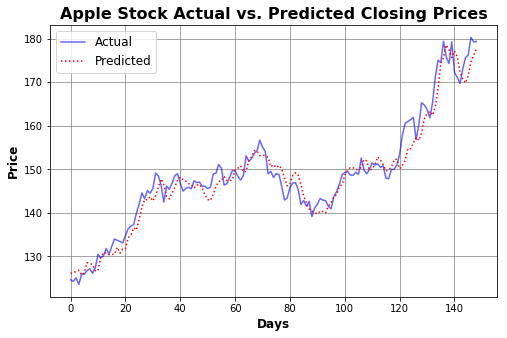

In [16]:
plt.figure(figsize=(8,5))
plt.plot(y_test, color = 'b', alpha = 0.6)
plt.plot(y_test_pred, linestyle='dotted', color = 'r')
plt.legend(['Actual','Predicted'], loc='best', prop={'size': 12})
plt.title('Apple Stock Actual vs. Predicted Closing Prices', weight='bold', fontsize=16)
plt.grid(color = 'gray', linewidth='0.7')
plt.ylabel('Price', weight='bold', fontsize=12)
plt.xlabel('Days', weight='bold', fontsize=12)
plt.show()

## Calculate:

<ul>
<li>R-Squared Score</li>
<li>Mean Squared Log Error (MSLE)</li>
<li>Mean Absolute Percentage Error (MAPE)</li>
</ul>

In [17]:
from sklearn import metrics
score = r2_score(y_test, y_test_pred)
print('\x1b[1;03;30;46m'+'R-Squared Score:', round(score,4), '\x1b[0m')
MSLE = metrics.mean_squared_log_error(y_test, y_test_pred)
print('\x1b[1;03;30;46m'+'\nMean Squared Log Error:', round(MSLE,4), '\x1b[0m')

R-Squared Score: 0.9498 

Mean Squared Log Error: 0.0003 


In [18]:
def mape(predictions, actuals):
    """Mean absolute percentage error"""
    predictions = np.array(predictions)
    actuals = np.array(actuals)
    return (np.absolute(predictions - actuals) / actuals).mean()

print('\x1b[1;03;30;46m'+'Mean Absolute Percentage Error (MAPE): '
      , round(mape(y_test_pred, y_test)*100,2), '%''\x1b[0m')

Mean Absolute Percentage Error (MAPE):  1.51 %
